In [269]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import plotly.express as px
import plotly.graph_objects as go
import statistics
from datetime import timedelta, datetime

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, classification_report, RocCurveDisplay, make_scorer
from xgboost import XGBClassifier
sns.set_theme()

## Load Data

In [270]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
display(train_df.head())
test_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [271]:
spray_df = pd.read_csv('../data/spray.csv')
spray_df.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [272]:
weather_df = pd.read_csv('../data/weather.csv')
weather_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


## EDA & Preprocessing

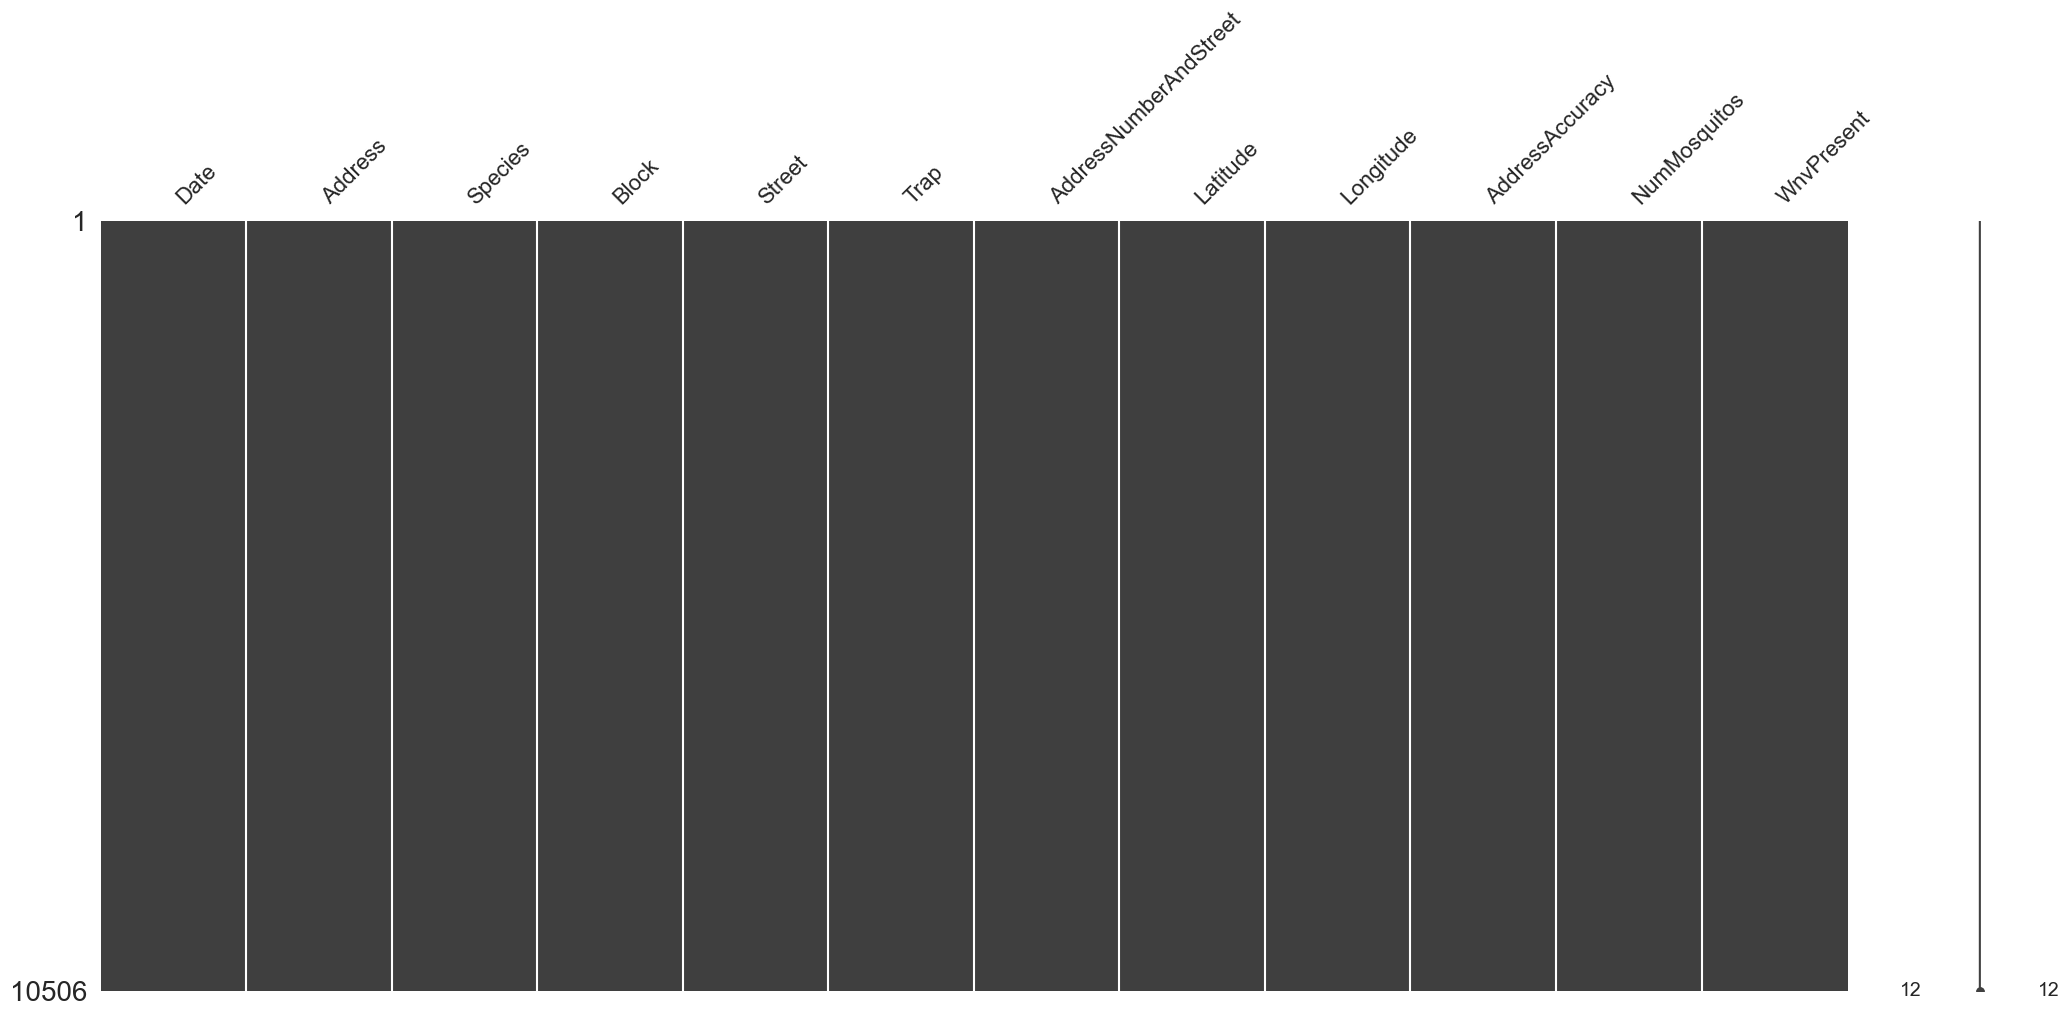

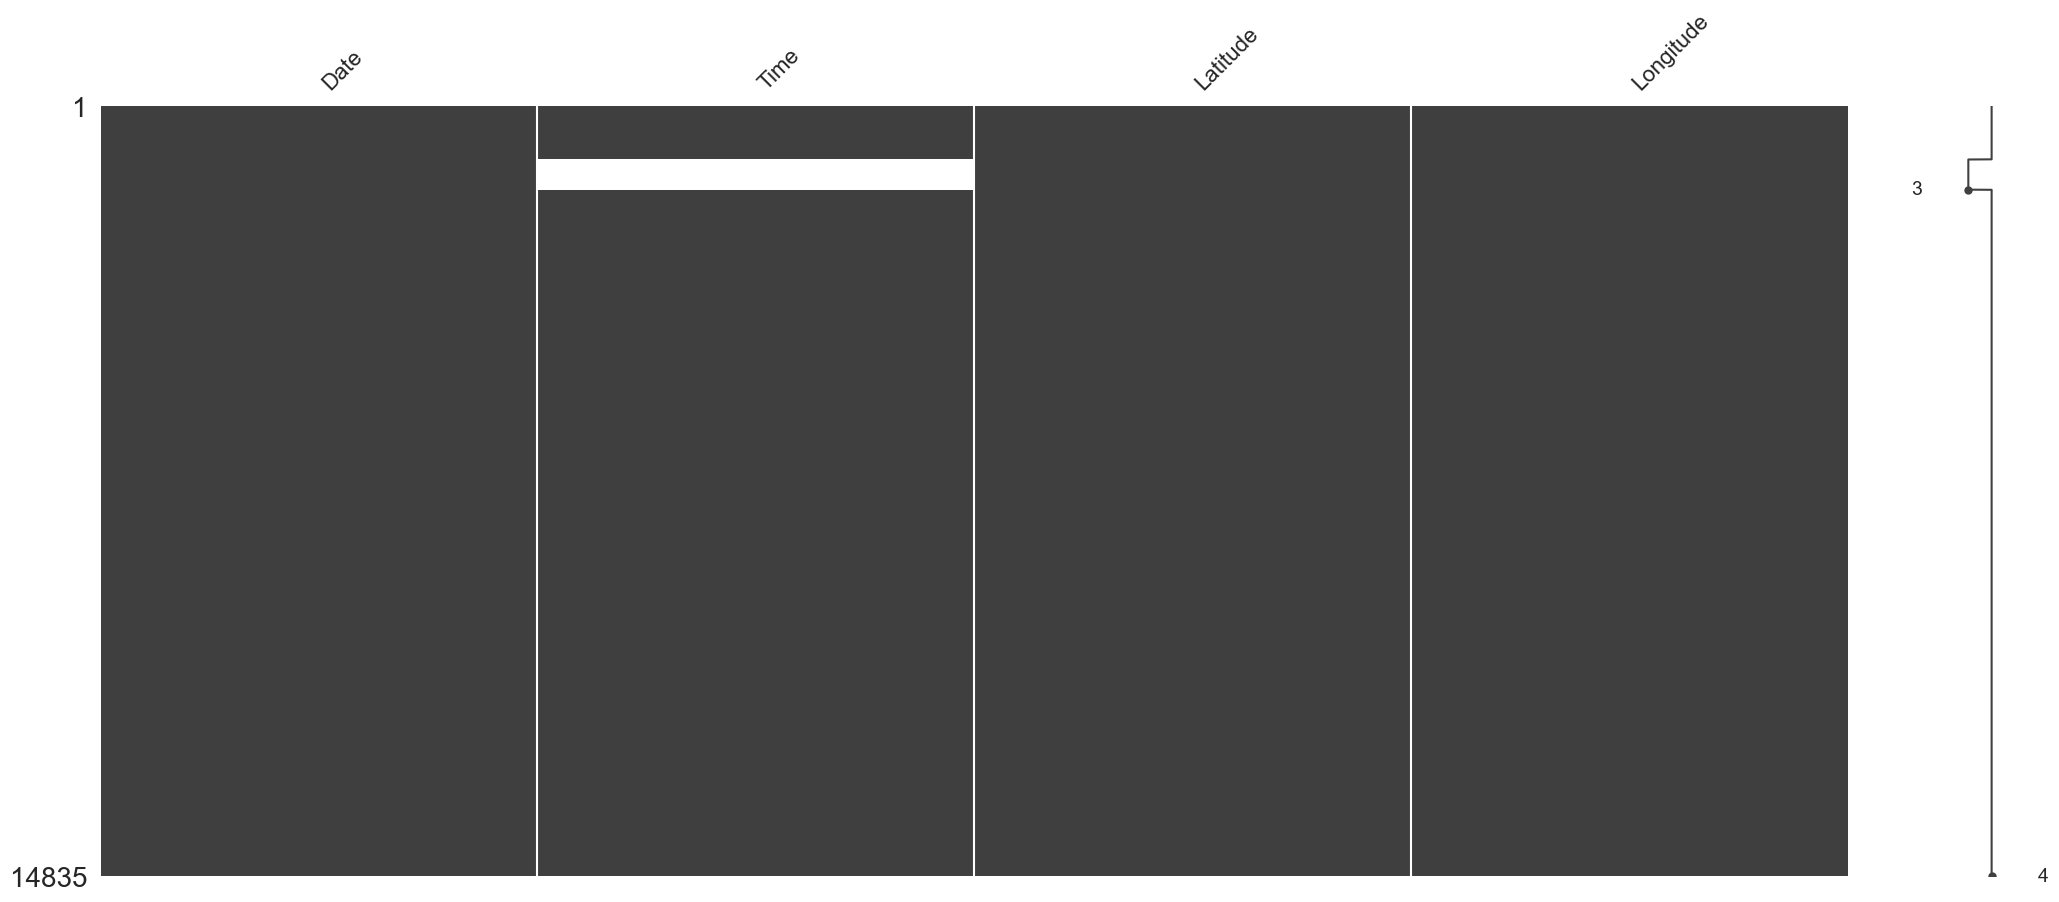

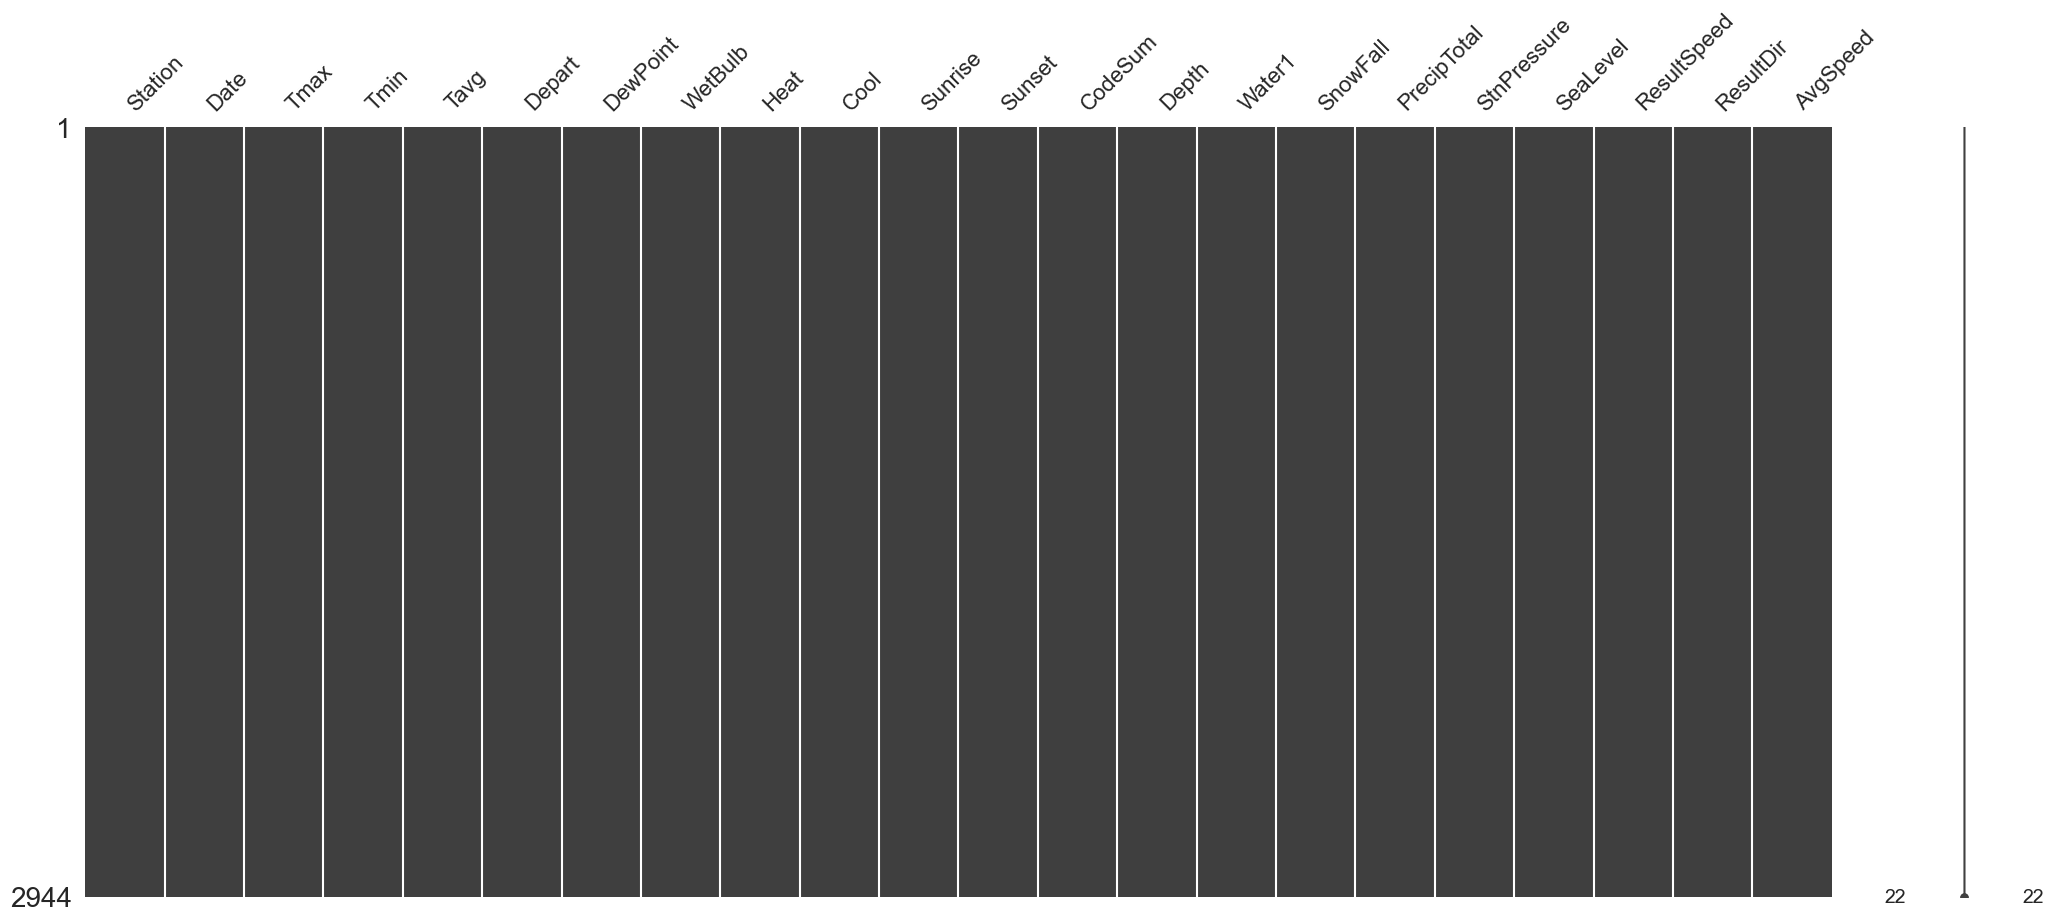

In [273]:
# Mssing values
msno.matrix(train_df)
msno.matrix(spray_df)
msno.matrix(weather_df);

In [274]:
# Spray missing values
display(spray_df.isna().sum())
spray_df.shape

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

(14835, 4)

### Spray data cleaning

In [275]:
# Display spray data
spray_df.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [276]:
# Find incorrect format and values in spray data
display(spray_df.info())
for col in spray_df:
    print(col)
    print(spray_df[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


None

Date
['2011-08-29' '2011-09-07' '2013-07-17' '2013-07-25' '2013-08-08'
 '2013-08-15' '2013-08-16' '2013-08-22' '2013-08-29' '2013-09-05']
Time
['6:56:58 PM' '6:57:08 PM' '6:57:18 PM' ... '8:04:01 PM' '8:04:11 PM'
 '8:04:21 PM']
Latitude
[42.39162333 42.39134833 42.39102167 ... 42.00602167 42.00545333
 42.004805  ]
Longitude
[-88.08916333 -88.08915667 -88.08915833 ... -87.81739167 -87.81742333
 -87.81746   ]


In [277]:
# Drop 'Time' column
spray_df.drop(columns='Time', inplace=True)

In [278]:
# Convert date to datetime
spray_df['Date'] = pd.to_datetime(spray_df['Date'])
spray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14835 non-null  datetime64[ns]
 1   Latitude   14835 non-null  float64       
 2   Longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 347.8 KB


### Weather data cleaning

In [279]:
# Display weather data
weather_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [280]:
# Find incorrect format and values in weather data
display(weather_df.info())
for col in weather_df:
    print(col)
    print(weather_df[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

None

Station
[1 2]
Date
['2007-05-01' '2007-05-02' '2007-05-03' ... '2014-10-29' '2014-10-30'
 '2014-10-31']
Tmax
[ 83  84  59  60  66  67  78  68  82  80  77  76  70  73  64  65  69  90
  62  61  71  79  87  89  88  75  85  86  81  72  63  91  92  93  74  94
  54  53  56  57  58  55  50  95  52  47  45  51  48  44  49  46  96  99
 100 101  97  98 102 103 104  42  41]
Tmin
[50 52 42 43 46 48 49 51 53 54 47 60 61 63 56 59 44 57 45 55 66 65 70 68
 62 67 64 58 71 69 73 75 72 74 39 41 40 37 34 38 35 36 33 31 32 76 77 29
 78 79 80 81 82 83]
Tavg
['67' '68' '51' '52' '56' '58' 'M' '60' '59' '65' '70' '69' '71' '61' '55'
 '57' '73' '72' '53' '62' '63' '74' '75' '78' '76' '77' '66' '80' '64'
 '81' '82' '79' '85' '84' '83' '50' '49' '46' '48' '45' '54' '47' '44'
 '40' '41' '38' '39' '42' '37' '43' '86' '87' '89' '92' '88' '91' '93'
 '94' '90' '36']
Depart
['14' 'M' '-3' ' 2' ' 4' ' 5' '10' '12' '13' '-2' '15' '11' '-4' '-6' ' 8'
 '-5' ' 1' ' 9' ' 6' '-9' '-8' ' 3' ' 0' '-1' '-7' ' 7' '-14' '18' '16'

In [281]:
# Number of incorrect format and values in weather data
for col in weather_df:
    if weather_df[(weather_df[col] == 'M') | (weather_df[col] == '  T') | (weather_df[col] == '-')].shape[0] != 0:
        print(col)
        print('M', weather_df[(weather_df[col] == 'M')].shape)
        print('T', weather_df[(weather_df[col] == '  T')].shape)
        print('-', weather_df[(weather_df[col] == '-')].shape)

Tavg
M (11, 22)
T (0, 22)
- (0, 22)
Depart
M (1472, 22)
T (0, 22)
- (0, 22)
WetBulb
M (4, 22)
T (0, 22)
- (0, 22)
Heat
M (11, 22)
T (0, 22)
- (0, 22)
Cool
M (11, 22)
T (0, 22)
- (0, 22)
Sunrise
M (0, 22)
T (0, 22)
- (1472, 22)
Sunset
M (0, 22)
T (0, 22)
- (1472, 22)
Depth
M (1472, 22)
T (0, 22)
- (0, 22)
Water1
M (2944, 22)
T (0, 22)
- (0, 22)
SnowFall
M (1472, 22)
T (12, 22)
- (0, 22)
PrecipTotal
M (2, 22)
T (318, 22)
- (0, 22)
StnPressure
M (4, 22)
T (0, 22)
- (0, 22)
SeaLevel
M (9, 22)
T (0, 22)
- (0, 22)
AvgSpeed
M (3, 22)
T (0, 22)
- (0, 22)


In [282]:
# Drop column with a lot of missing/unusable values in weather
weather_df.drop(columns=['Depart', 'Sunrise', 'Sunset', 'Depth', 'Water1', 'SnowFall', 'CodeSum'], inplace=True)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   DewPoint     2944 non-null   int64  
 6   WetBulb      2944 non-null   object 
 7   Heat         2944 non-null   object 
 8   Cool         2944 non-null   object 
 9   PrecipTotal  2944 non-null   object 
 10  StnPressure  2944 non-null   object 
 11  SeaLevel     2944 non-null   object 
 12  ResultSpeed  2944 non-null   float64
 13  ResultDir    2944 non-null   int64  
 14  AvgSpeed     2944 non-null   object 
dtypes: float64(1), int64(5), object(9)
memory usage: 345.1+ KB


In [283]:
# Convert date to datetime
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

In [284]:
# Replace PrecipTotal 'T' (Trace) with very small value
weather_df['PrecipTotal'] = weather_df['PrecipTotal'].map(lambda x: 0.001 if x == '  T' else x)

In [285]:
# Replace 'M' value with NaN, prepare for imputer
weather_df.replace('M', np.nan, inplace=True)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2933 non-null   object        
 5   DewPoint     2944 non-null   int64         
 6   WetBulb      2940 non-null   object        
 7   Heat         2933 non-null   object        
 8   Cool         2933 non-null   object        
 9   PrecipTotal  2942 non-null   object        
 10  StnPressure  2940 non-null   object        
 11  SeaLevel     2935 non-null   object        
 12  ResultSpeed  2944 non-null   float64       
 13  ResultDir    2944 non-null   int64         
 14  AvgSpeed     2941 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(8)
m

In [286]:
# Convert all object field to float
weather_df[['Tavg', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']] = weather_df[['Tavg', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']].astype(float)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2933 non-null   float64       
 5   DewPoint     2944 non-null   int64         
 6   WetBulb      2940 non-null   float64       
 7   Heat         2933 non-null   float64       
 8   Cool         2933 non-null   float64       
 9   PrecipTotal  2942 non-null   float64       
 10  StnPressure  2940 non-null   float64       
 11  SeaLevel     2935 non-null   float64       
 12  ResultSpeed  2944 non-null   float64       
 13  ResultDir    2944 non-null   int64         
 14  AvgSpeed     2941 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(5)
memory usage

In [287]:
# Separate weather into 2 df (station 1 and 2)
weather_df_station_1 = weather_df[weather_df['Station'] == 1].drop(columns='Station')
weather_df_station_2 = weather_df[weather_df['Station'] == 2].drop(columns='Station')

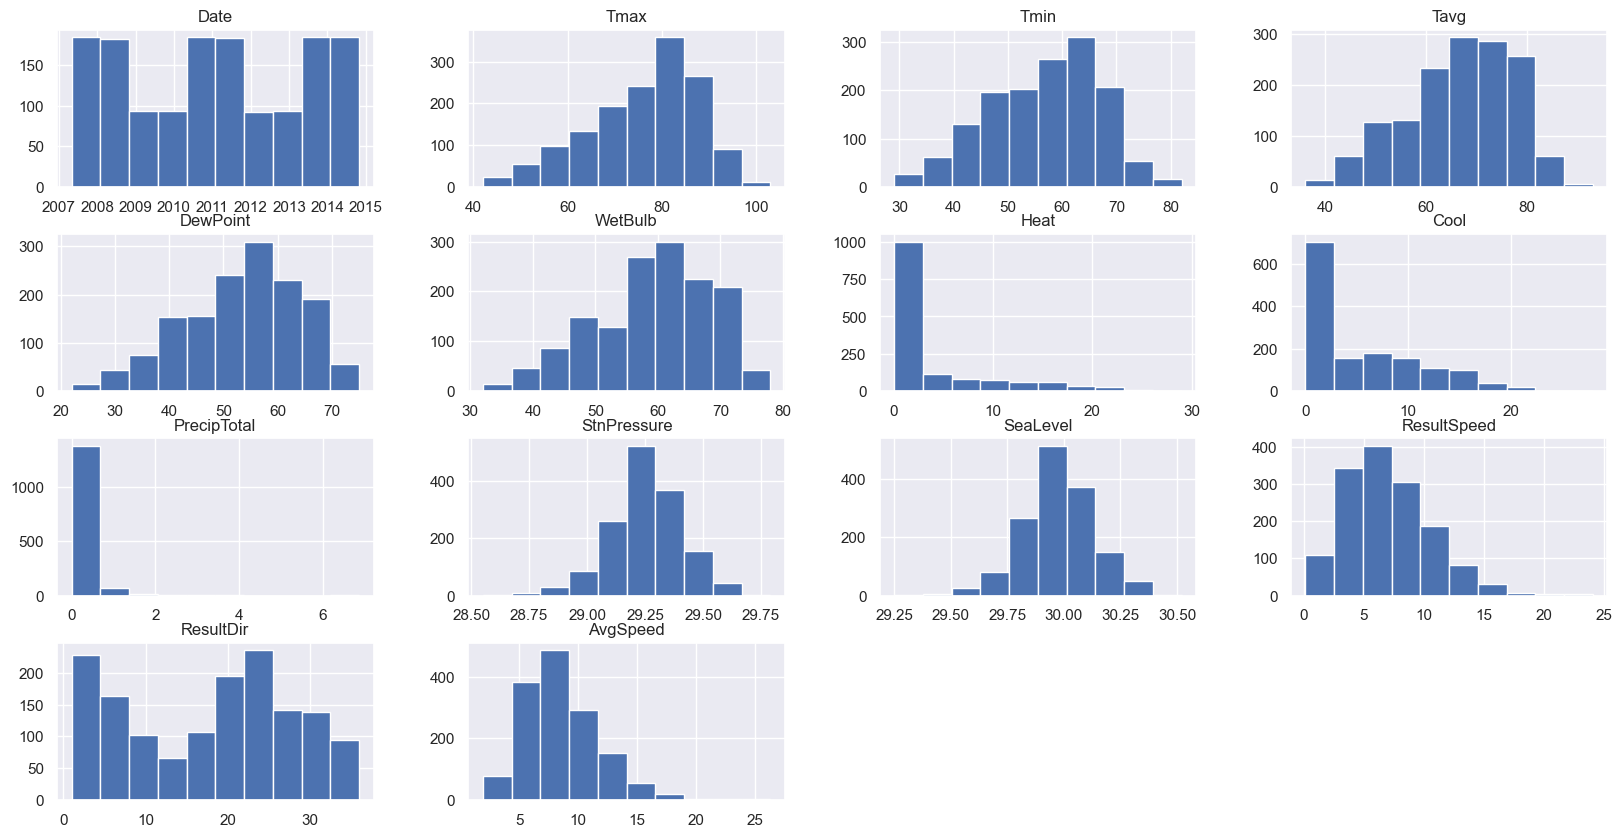

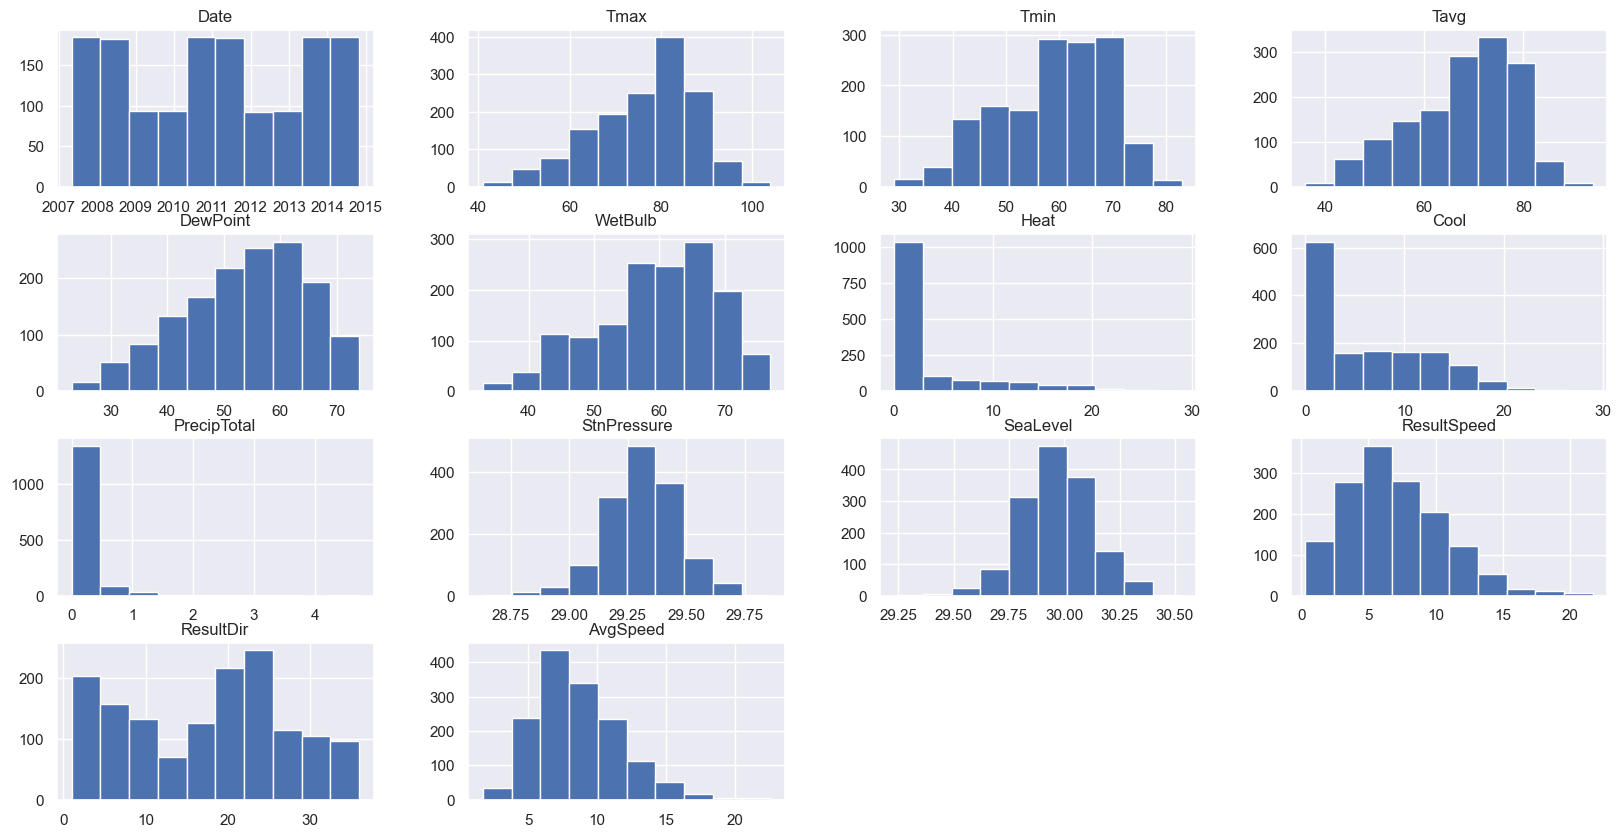

In [288]:
# Data from 2 stations is a little bit different (not that much)
weather_df_station_1.hist(figsize=(20, 10))
weather_df_station_2.hist(figsize=(20, 10));

In [289]:
# Create new weather df, average data from 2 stations. If one missing, using the other one instead
weather_df_avg = (weather_df_station_1.set_index('Date') + weather_df_station_2.set_index('Date')) / 2
weather_df_avg = weather_df_avg.combine_first(weather_df_station_1.set_index('Date')).combine_first(weather_df_station_2.set_index('Date'))
weather_df_avg.reset_index(inplace=True)

display(weather_df_avg.info())
weather_df_avg.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1472 non-null   datetime64[ns]
 1   Tmax         1472 non-null   float64       
 2   Tmin         1472 non-null   float64       
 3   Tavg         1472 non-null   float64       
 4   DewPoint     1472 non-null   float64       
 5   WetBulb      1472 non-null   float64       
 6   Heat         1472 non-null   float64       
 7   Cool         1472 non-null   float64       
 8   PrecipTotal  1472 non-null   float64       
 9   StnPressure  1471 non-null   float64       
 10  SeaLevel     1472 non-null   float64       
 11  ResultSpeed  1472 non-null   float64       
 12  ResultDir    1472 non-null   float64       
 13  AvgSpeed     1472 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 161.1 KB


None

,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-01,83.5,51.0,67.5,51.0,56.5,0.0,2.5,0.0000,29.140,29.820,2.20,26.0,9.40
1,2007-05-02,59.5,42.5,51.5,42.0,47.0,13.5,0.0,0.0000,29.410,30.085,13.15,3.0,13.40
2,2007-05-03,66.5,47.0,57.0,40.0,49.0,8.0,0.0,0.0000,29.425,30.120,12.30,6.5,12.55
3,2007-05-04,72.0,50.0,58.0,41.5,50.0,7.0,0.0,0.0005,29.335,30.045,10.25,7.5,10.60
4,2007-05-05,66.0,53.5,60.0,38.5,49.5,5.0,0.0,0.0010,29.430,30.095,11.45,7.0,11.75


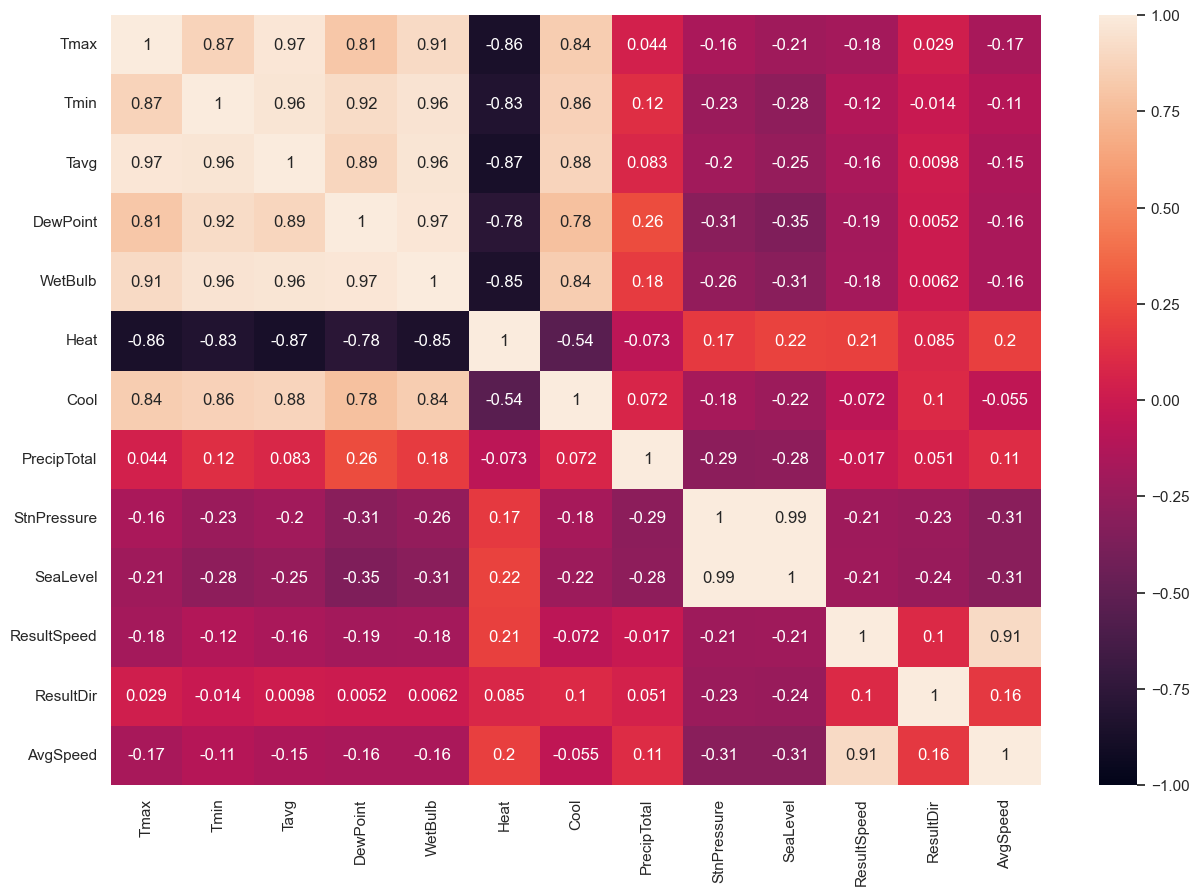

In [290]:
# Correlation
plt.figure(figsize=(15, 10))
sns.heatmap(weather_df_avg.corr(numeric_only=True), annot=True, vmin=-1, vmax=1);

In [291]:
# Drop Tmin, Tmax, Heat, Cool, WetBulb, DewPoint (strong correlation with Tavg) ResultSpeed (Strong correlation with AvgSpeed) SeaLevel (Strong correlation with StnPressure)
weather_df_avg.drop(columns=['Tmin', 'Tmax', 'Heat', 'Cool', 'WetBulb', 'DewPoint', 'ResultSpeed', 'SeaLevel'], inplace=True)

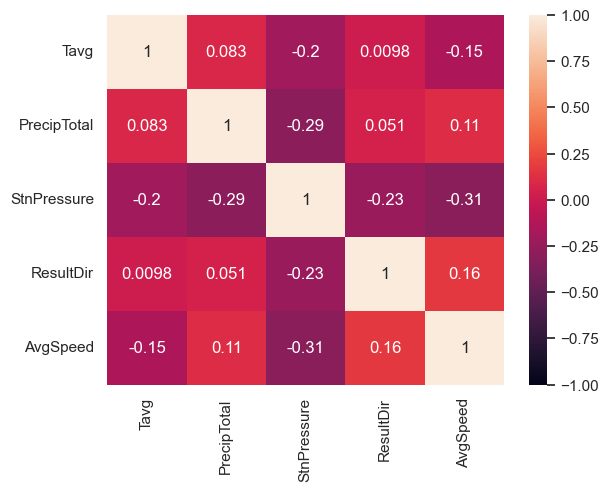

In [292]:
# Recheck Correlation
sns.heatmap(weather_df_avg.corr(numeric_only=True), annot=True, vmin=-1, vmax=1);

In [293]:
# Extract weeknum and year
# weather_df_avg['weeknum'] = weather_df_avg['Date'].dt.strftime("%U").astype(int)
# weather_df_avg['year'] = weather_df_avg['Date'].dt.year

In [294]:
# Set date as index for timeseries processing
weather_df_avg.set_index('Date', inplace=True)
weather_df_avg.head()

,Tavg,PrecipTotal,StnPressure,ResultDir,AvgSpeed
Date,,,,,
2007-05-01,67.5,0.0000,29.140,26.0,9.40
2007-05-02,51.5,0.0000,29.410,3.0,13.40
2007-05-03,57.0,0.0000,29.425,6.5,12.55
2007-05-04,58.0,0.0005,29.335,7.5,10.60
2007-05-05,60.0,0.0010,29.430,7.0,11.75


In [295]:
weather_df_avg.rolling(14).mean().reset_index()

,Date,Tavg,PrecipTotal,StnPressure,ResultDir,AvgSpeed
0,2007-05-01,NaN,NaN,NaN,NaN,NaN
1,2007-05-02,NaN,NaN,NaN,NaN,NaN
2,2007-05-03,NaN,NaN,NaN,NaN,NaN
3,2007-05-04,NaN,NaN,NaN,NaN,NaN
4,2007-05-05,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1467,2014-10-27,54.464286,0.072286,29.228571,22.178571,9.046429
1468,2014-10-28,54.250000,0.008036,29.252143,23.250000,9.453571
1469,2014-10-29,53.500000,0.003750,29.274643,22.821429,9.428571
1470,2014-10-30,52.714286,0.003714,29.297500,22.750000,9.292857


In [296]:
weather_df_avg.resample('2W').mean().reset_index()

,Date,Tavg,PrecipTotal,StnPressure,ResultDir,AvgSpeed
0,2007-05-06,58.916667,0.000250,29.389167,10.083333,12.075000
1,2007-05-20,62.785714,0.054357,29.380714,15.535714,9.917857
2,2007-06-03,70.535714,0.101214,29.326429,16.964286,8.889286
3,2007-06-17,72.000000,0.055821,29.241071,14.928571,8.800000
4,2007-07-01,71.785714,0.102643,29.367500,12.607143,9.032143
...,...,...,...,...,...,...
192,2014-09-14,67.250000,0.177179,29.346071,24.714286,9.075000
193,2014-09-28,63.714286,0.008714,29.440000,17.892857,6.167857
194,2014-10-12,55.428571,0.105214,29.203571,18.714286,9.675000
195,2014-10-26,54.321429,0.110143,29.231429,21.857143,8.742857


In [297]:
weather_df_avg

,Tavg,PrecipTotal,StnPressure,ResultDir,AvgSpeed
Date,,,,,
2007-05-01,67.5,0.0000,29.140,26.0,9.40
2007-05-02,51.5,0.0000,29.410,3.0,13.40
2007-05-03,57.0,0.0000,29.425,6.5,12.55
2007-05-04,58.0,0.0005,29.335,7.5,10.60
2007-05-05,60.0,0.0010,29.430,7.0,11.75
...,...,...,...,...,...
2014-10-27,65.5,0.0100,28.960,19.0,13.25
2014-10-28,57.0,0.0155,29.190,26.0,15.10
2014-10-29,44.0,0.0000,29.390,29.0,9.45


### Train data cleaning

In [298]:
# Display train data
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [299]:
# Find incorrect format and values in train data
display(train_df.info())
for col in train_df:
    print(col)
    print(train_df[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


None

Date
['2007-05-29' '2007-06-05' '2007-06-26' '2007-06-29' '2007-07-02'
 '2007-07-11' '2007-07-18' '2007-07-19' '2007-07-25' '2007-07-27'
 '2007-08-01' '2007-08-02' '2007-08-03' '2007-08-07' '2007-08-08'
 '2007-08-09' '2007-08-15' '2007-08-16' '2007-08-17' '2007-08-21'
 '2007-08-22' '2007-08-24' '2007-08-28' '2007-09-04' '2007-09-05'
 '2007-09-06' '2007-09-12' '2007-09-18' '2007-09-19' '2007-09-24'
 '2007-09-25' '2007-10-04' '2007-10-09' '2009-05-28' '2009-06-02'
 '2009-06-03' '2009-06-05' '2009-06-12' '2009-06-15' '2009-06-19'
 '2009-06-22' '2009-06-26' '2009-06-29' '2009-07-06' '2009-07-10'
 '2009-07-13' '2009-07-17' '2009-07-24' '2009-07-27' '2009-07-31'
 '2009-08-07' '2009-08-13' '2009-08-25' '2009-08-27' '2009-09-03'
 '2009-09-14' '2009-09-17' '2009-09-25' '2009-10-01' '2011-06-10'
 '2011-06-17' '2011-06-24' '2011-06-30' '2011-07-11' '2011-07-15'
 '2011-07-25' '2011-07-29' '2011-08-05' '2011-08-12' '2011-08-19'
 '2011-08-26' '2011-09-01' '2011-09-02' '2011-09-12' '2011-09-16'
 '201

In [300]:
# Convert Date to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

In [301]:
# col = list(train_df.drop(columns=['NumMosquitos', 'WnvPresent']).columns)
# grouped_df = train_df.copy()
# grouped_df['Count'] = train_df.groupby(col, as_index=False)['NumMosquitos'].transform('count')
# grouped_df

In [302]:
# grouped_df[grouped_df['Date'].dt.month == 8]['Date'].unique()

In [303]:
# grouped_df[grouped_df['Date'] == '2009-08-27']

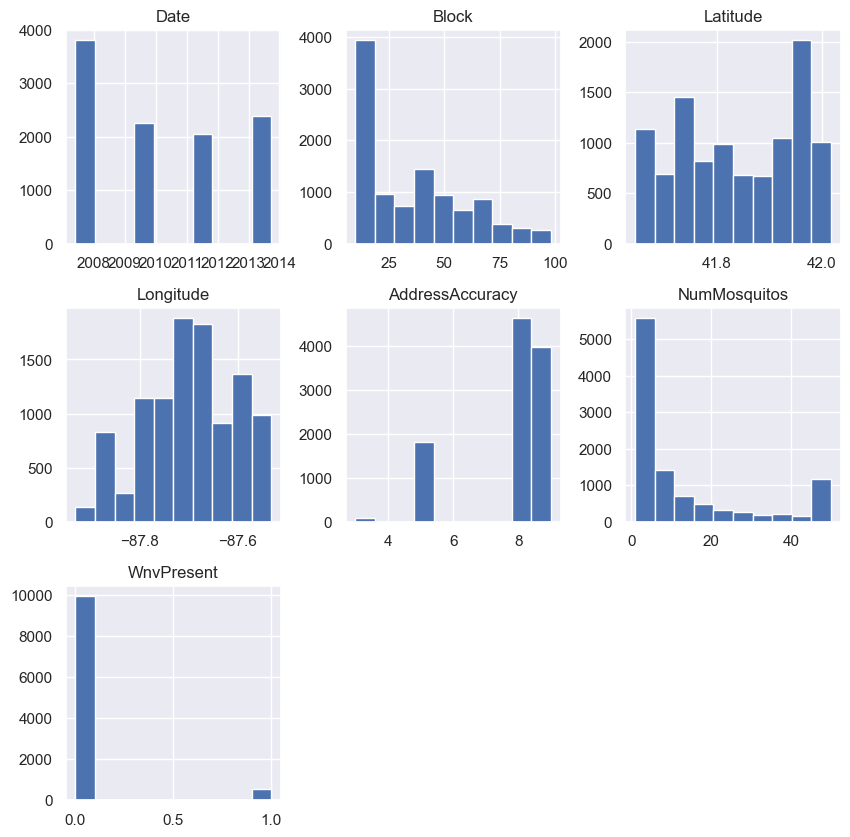

In [304]:
# Train data distribution
train_df.hist(figsize=(10, 10));

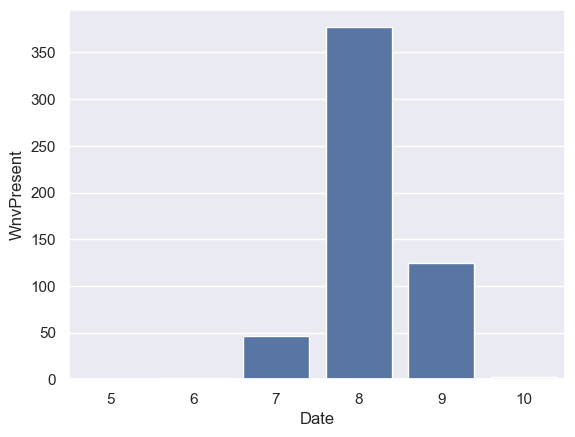

In [305]:
# Target variable (west nile virus present) group by month
sns.barplot(train_df.groupby(train_df['Date'].dt.month)['WnvPresent'].sum());

In [306]:
# Proportion of target variable classes
train_df[train_df['Date'].dt.month.isin([8, 9])]['WnvPresent'].value_counts(normalize=True)

WnvPresent
0    0.915899
1    0.084101
Name: proportion, dtype: float64

In [307]:
# Check test data features (no NumMosquitos, cannot be used as a predictor)
test_df.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [308]:
# Drop 'Address', 'Street', 'AddressNumberAndStreet', uses 'Block' and 'Latitude', 'Longitude' instead
train_df.drop(columns=['Address', 'Street', 'AddressNumberAndStreet'], inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             10506 non-null  datetime64[ns]
 1   Species          10506 non-null  object        
 2   Block            10506 non-null  int64         
 3   Trap             10506 non-null  object        
 4   Latitude         10506 non-null  float64       
 5   Longitude        10506 non-null  float64       
 6   AddressAccuracy  10506 non-null  int64         
 7   NumMosquitos     10506 non-null  int64         
 8   WnvPresent       10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 738.8+ KB


In [309]:
train_df.columns

Index(['Date', 'Species', 'Block', 'Trap', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent'],
      dtype='object')

Species                 WnvPresent
CULEX ERRATICUS         0                1
CULEX PIPIENS           0             2459
                        1              240
CULEX PIPIENS/RESTUANS  0             4490
                        1              262
CULEX RESTUANS          0             2691
                        1               49
CULEX SALINARIUS        0               86
CULEX TARSALIS          0                6
CULEX TERRITANS         0              222
Name: count, dtype: int64

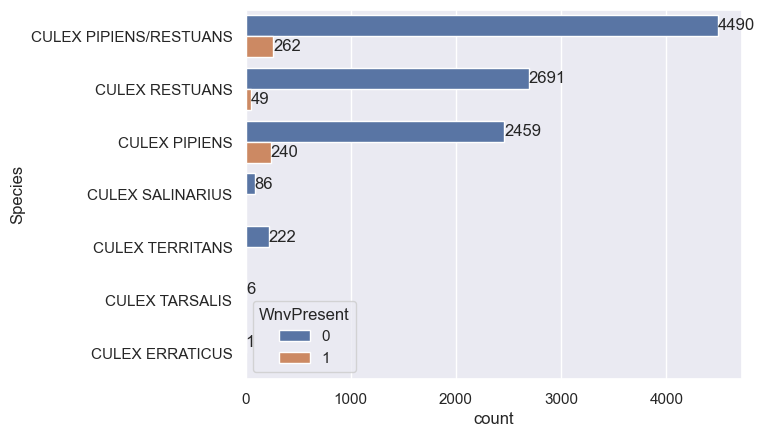

In [310]:
# WnvPresent in each species
display(train_df.groupby('Species')['WnvPresent'].value_counts())
ax = sns.countplot(train_df, y='Species', hue='WnvPresent')
for container in ax.containers:
    plt.bar_label(container);

In [311]:
train_df

,Date,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,T002,41.954690,-87.800991,9,1,0
1,2007-05-29,CULEX RESTUANS,41,T002,41.954690,-87.800991,9,1,0
2,2007-05-29,CULEX RESTUANS,62,T007,41.994991,-87.769279,9,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,T015,41.974089,-87.824812,8,1,0
4,2007-05-29,CULEX RESTUANS,79,T015,41.974089,-87.824812,8,4,0
...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,CULEX PIPIENS/RESTUANS,51,T035,41.763733,-87.742302,8,6,1
10502,2013-09-26,CULEX PIPIENS/RESTUANS,58,T231,41.987280,-87.666066,8,5,0
10503,2013-09-26,CULEX PIPIENS/RESTUANS,17,T232,41.912563,-87.668055,9,1,0
10504,2013-09-26,CULEX PIPIENS/RESTUANS,71,T233,42.009876,-87.807277,9,5,0


In [312]:
# Number of blocks per trap, there are 1 trap that located in 2 block
print(train_df[['Trap', 'Block']].drop_duplicates().groupby('Trap').count().value_counts())
display(train_df[['Trap', 'Block']].drop_duplicates().groupby('Trap').count().sort_values(by='Block', ascending=False))

display(train_df[train_df['Trap'] == 'T035'][['Latitude', 'Longitude', 'Block']].value_counts())

Block
1        135
2          1
Name: count, dtype: int64


,Block
Trap,
T035,2
T001,1
T142,1
T143,1
T144,1
...,...
T054C,1
T054,1
T051,1


Latitude   Longitude   Block
41.763733  -87.742302  51       45
41.836644  -87.677737  30       27
Name: count, dtype: int64

In [313]:
# Check block location, is that unique, no overlap ?
print(train_df[['Latitude', 'Longitude', 'Block']].drop_duplicates().groupby(['Latitude', 'Longitude']).count().value_counts())
train_df[['Latitude', 'Longitude', 'Block']].drop_duplicates().groupby(['Latitude', 'Longitude']).count().sort_values(by='Block', ascending=False)

Block
1        138
Name: count, dtype: int64


,,Block
Latitude,Longitude,
41.644612,-87.604498,1
41.923738,-87.785288,1
41.916265,-87.800515,1
41.918705,-87.752329,1
41.919343,-87.694259,1
...,...,...
41.771660,-87.703047,1
41.768388,-87.678649,1
41.766202,-87.562889,1


In [314]:
# Extract weeknum and year
train_df['weeknum'] = train_df['Date'].dt.strftime("%U").astype(int)
train_df['year'] = train_df['Date'].dt.year

In [315]:
# Drop Trap, and Latitude, Longitude, 'AddressAccuracy' and uses only block
animate_df = train_df.copy() # Copy for visualization before dropping columns
train_df.drop(columns=['Trap', 'Latitude', 'Longitude', 'AddressAccuracy'], inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          10506 non-null  datetime64[ns]
 1   Species       10506 non-null  object        
 2   Block         10506 non-null  int64         
 3   NumMosquitos  10506 non-null  int64         
 4   WnvPresent    10506 non-null  int64         
 5   weeknum       10506 non-null  int32         
 6   year          10506 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(3), object(1)
memory usage: 492.6+ KB


In [316]:
all_col = ['Species', 'Block', 'NumMosquitos', 'WnvPresent', 'weeknum', 'year']
group_col = ['year', 'weeknum', 'Species', 'Block']

filter_year = train_df['year'] == 2013
filter_weeknum = train_df['weeknum'] == 33
filter_species = train_df['Species'] == 'CULEX PIPIENS/RESTUANS'
filter_block = train_df['Block'] == 39

train_df[filter_year & filter_weeknum & filter_species & filter_block].count().values[0]
# train_df[all_col].groupby(group_col, as_index=False).count()[filter_year & filter_weeknum & filter_species & filter_block]['NumMosquitos'].values[0]

2

In [317]:
def count_prev_week(row, weeks=1):
    all_col = ['Species', 'Block', 'NumMosquitos', 'WnvPresent', 'weeknum', 'year']
    group_col = ['year', 'weeknum', 'Species', 'Block']

    filter_year = train_df['year'] == row['year']
    filter_weeknum = (train_df['weeknum'] == row['weeknum']-weeks)
    filter_species = train_df['Species'] == row['Species']
    filter_block = train_df['Block'] == row['Block']

    return train_df[filter_year & filter_weeknum & filter_species & filter_block].count().values[0]

    # return train_df[all_col].groupby(group_col, as_index=False).count()[filter_year & filter_weeknum & filter_species & filter_block]['NumMosquitos'].values[0]

In [318]:
train_df['count_prev_week_records'] = train_df.apply(lambda row: count_prev_week(row, 1), axis=1)
train_df['count_prev_2week_records'] = train_df.apply(lambda row: count_prev_week(row, 2), axis=1)

### Create new dataframe, block WnvPresent probabilities on each week and year

In [319]:
train_df.head()

,Date,Species,Block,NumMosquitos,WnvPresent,weeknum,year,count_prev_week_records,count_prev_2week_records
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,1,0,21,2007,0,0
1,2007-05-29,CULEX RESTUANS,41,1,0,21,2007,0,0
2,2007-05-29,CULEX RESTUANS,62,1,0,21,2007,0,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,1,0,21,2007,0,0
4,2007-05-29,CULEX RESTUANS,79,4,0,21,2007,0,0


In [320]:
temp_df = train_df.loc[train_df['WnvPresent'] == 0, ['Species', 'Block', 'NumMosquitos', 'WnvPresent', 'weeknum', 'year']].groupby(['Species', 'Block', 'weeknum', 'year'], as_index=False)['NumMosquitos'].count().rename(columns={'NumMosquitos': 'count_wnv_not_present'})
temp_df = temp_df.groupby(['Species', 'Block', 'weeknum'], as_index=False)['count_wnv_not_present'].mean()

In [321]:
temp_df_2 = train_df.loc[train_df['WnvPresent'] == 1, ['Species', 'Block', 'NumMosquitos', 'WnvPresent', 'weeknum', 'year']].groupby(['Species', 'Block', 'weeknum', 'year'], as_index=False)['NumMosquitos'].count().rename(columns={'NumMosquitos': 'count_wnv_present'})
temp_df_2 = temp_df_2.groupby(['Species', 'Block', 'weeknum'], as_index=False)['count_wnv_present'].mean()

In [322]:
temp_df

,Species,Block,weeknum,count_wnv_not_present
0,CULEX ERRATICUS,10,35,1.0
1,CULEX PIPIENS,10,22,4.0
2,CULEX PIPIENS,10,23,2.0
3,CULEX PIPIENS,10,24,3.0
4,CULEX PIPIENS,10,25,2.0
...,...,...,...,...
2593,CULEX TERRITANS,89,31,1.0
2594,CULEX TERRITANS,89,33,1.0
2595,CULEX TERRITANS,89,35,1.0
2596,CULEX TERRITANS,90,28,1.0


In [323]:
temp_df = temp_df.merge(right=temp_df_2, on=['Species', 'Block', 'weeknum'], how='left').fillna(0)
temp_df

,Species,Block,weeknum,count_wnv_not_present,count_wnv_present
0,CULEX ERRATICUS,10,35,1.0,0.0
1,CULEX PIPIENS,10,22,4.0,0.0
2,CULEX PIPIENS,10,23,2.0,0.0
3,CULEX PIPIENS,10,24,3.0,0.0
4,CULEX PIPIENS,10,25,2.0,0.0
...,...,...,...,...,...
2593,CULEX TERRITANS,89,31,1.0,0.0
2594,CULEX TERRITANS,89,33,1.0,0.0
2595,CULEX TERRITANS,89,35,1.0,0.0
2596,CULEX TERRITANS,90,28,1.0,0.0


In [324]:
wnv_proportion_df = pd.DataFrame(temp_df.groupby('Block')['count_wnv_present'].mean()/temp_df.groupby('Block')['count_wnv_not_present'].mean(), columns=['wnv_present_proportion']).reset_index()
wnv_proportion_df

,Block,wnv_present_proportion
0,10,0.110851
1,11,0.089616
2,12,0.164095
3,13,0.065894
4,14,0.110497
...,...,...
59,90,0.086643
60,91,0.148377
61,93,0.000000
62,96,0.000000


In [325]:
train_df = train_df.merge(right=wnv_proportion_df, on='Block', how='left').fillna(0)

## Map visualization

In [326]:
# Spray area
fig = px.scatter_mapbox(
    data_frame=spray_df,
    lat="Latitude", lon="Longitude",
    zoom=9.5,
    color='Date',
    height=800, width=800,
    mapbox_style='open-street-map')

fig.show();

In [327]:
# Sum NumMosquitos and WnvPresent from multiple splitted record
col = list(animate_df.drop(columns=['NumMosquitos', 'WnvPresent']).columns)
animate_df = animate_df.groupby(col, as_index=False)[['NumMosquitos', 'WnvPresent']].sum()

In [328]:
# Correcting WnvPresent values
animate_df['WnvPresent'] = animate_df['WnvPresent'].map(lambda x: 0 if x == 0 else 1)

In [329]:
# Prepare plot data, number of mosquitos and WnvPresent over time
animate_df['year_month'] = animate_df.apply(lambda x: str(x['Date'].year) + str(x['Date'].month).zfill(2), axis=1)
animate_df['year_week'] = animate_df.apply(lambda x: str(x['year']) + str(x['weeknum'] + x['weeknum']%2).zfill(2), axis=1)
animate_df

,Date,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,weeknum,year,NumMosquitos,WnvPresent,year_month,year_week
0,2007-05-29,CULEX PIPIENS,22,T096,41.731922,-87.677512,8,21,2007,1,0,200705,200722
1,2007-05-29,CULEX PIPIENS/RESTUANS,11,T048,41.867108,-87.654224,8,21,2007,1,0,200705,200722
2,2007-05-29,CULEX PIPIENS/RESTUANS,21,T050,41.919343,-87.694259,8,21,2007,1,0,200705,200722
3,2007-05-29,CULEX PIPIENS/RESTUANS,22,T054,41.921965,-87.632085,8,21,2007,2,0,200705,200722
4,2007-05-29,CULEX PIPIENS/RESTUANS,22,T086,41.688324,-87.676709,8,21,2007,1,0,200705,200722
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,2013-09-26,CULEX RESTUANS,13,T209,41.740641,-87.546587,5,38,2013,1,0,201309,201338
8471,2013-09-26,CULEX RESTUANS,40,T221,41.659112,-87.538693,8,38,2013,5,0,201309,201338
8472,2013-09-26,CULEX RESTUANS,45,T220,41.963976,-87.691810,9,38,2013,8,0,201309,201338
8473,2013-09-26,CULEX RESTUANS,50,T082,41.803423,-87.642984,8,38,2013,2,0,201309,201338


In [330]:
# Plot number of mosquitos in traps with Wnv present or not
# print(spray_df['Date'].unique())

fig = px.scatter_mapbox(
    data_frame=animate_df,
    lat="Latitude", lon="Longitude",
    zoom=9.5,
    hover_name='Species',
    size='NumMosquitos',
    color='WnvPresent',
    size_max=80,
    animation_frame='year_week',
    range_color=[0, 1],
    height=800, width=800,
    mapbox_style='open-street-map'
)

fig.show()

## Join data

In [331]:
train_df['Date'] = pd.to_datetime(train_df['Date'])

In [332]:
# Impute missing data
knn_imp = KNNImputer()
weather_df_avg['StnPressure'] = knn_imp.fit_transform(weather_df_avg[['StnPressure']])

In [333]:
weather_df_rolling_avg = weather_df_avg.rolling('7D').mean().reset_index()

In [334]:
combined_df = train_df.merge(
    right=weather_df_avg,
    on='Date'
)

combined_df.head()

,Date,Species,Block,NumMosquitos,WnvPresent,weeknum,year,count_prev_week_records,count_prev_2week_records,wnv_present_proportion,Tavg,PrecipTotal,StnPressure,ResultDir,AvgSpeed
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,1,0,21,2007,0,0,0.196841,75.5,0.0,29.415,17.0,6.95
1,2007-05-29,CULEX RESTUANS,41,1,0,21,2007,0,0,0.196841,75.5,0.0,29.415,17.0,6.95
2,2007-05-29,CULEX RESTUANS,62,1,0,21,2007,0,0,0.024793,75.5,0.0,29.415,17.0,6.95
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,1,0,21,2007,0,0,0.109756,75.5,0.0,29.415,17.0,6.95
4,2007-05-29,CULEX RESTUANS,79,4,0,21,2007,0,0,0.109756,75.5,0.0,29.415,17.0,6.95


## Modelling

In [335]:
num_features = ['weeknum', 'year', 'Tavg', 'PrecipTotal', 'StnPressure', 'ResultDir', 'AvgSpeed']
cat_features = ['Species', 'Block']
eng_features = ['count_prev_week_records', 'wnv_present_proportion']

X = pd.get_dummies(combined_df[num_features + cat_features + eng_features], columns=cat_features, drop_first=True)
# X = combined_df[num_features + cat_features]
y = combined_df['WnvPresent']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [336]:
# Scale & Oversampling
from imblearn.over_sampling import SMOTE

ss = StandardScaler()
sm = SMOTE()

X_train_sc = ss.fit_transform(X_train)
Xsm_train, ysm_train = sm.fit_resample(X_train_sc, y_train)

In [337]:
X_val_sc = ss.transform(X_val)

### Logistic Regression

In [338]:
lr = LogisticRegression(max_iter=1000)
lr.fit(Xsm_train, ysm_train)

LogisticRegression(max_iter=1000)

In [339]:
lr.score(Xsm_train, ysm_train)

0.74196356817573

In [340]:
lr.score(X_val_sc, y_val)

0.671488389798249

### Random Forest

In [341]:
rf = RandomForestClassifier()
rf.fit(Xsm_train, ysm_train)

RandomForestClassifier()

In [342]:
rf.score(Xsm_train, ysm_train)

0.9742834181623359

In [343]:
rf.score(X_val_sc, y_val)

0.9215835553863723

### XGBoost

In [344]:
xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [345]:
xgb.score(Xsm_train, ysm_train)

0.9671845700508974

In [346]:
xgb.score(X_val_sc, y_val)

0.9227255424438523

### # Retrain with full dataset

In [347]:
X_sc = ss.fit_transform(X)
Xsm, ysm = sm.fit_resample(X_sc, y)

lr.fit(Xsm, ysm)
rf.fit(Xsm, ysm)
xgb.fit(Xsm, ysm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Submission

In [348]:
# Preprocess data
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['weeknum'] = test_df['Date'].dt.strftime("%U").astype(int)
test_df['year'] = test_df['Date'].dt.year

test_df['count_prev_week_records'] = test_df.apply(lambda row: count_prev_week(row, 1), axis=1)
test_df['count_prev_2week_records'] = test_df.apply(lambda row: count_prev_week(row, 2), axis=1)

In [349]:
# Join to get eng. feature
test_df = test_df.merge(right=wnv_proportion_df, on='Block', how='left').fillna(0)

In [350]:
# Join with weather
combined_test_df = test_df.merge(
    right=weather_df_avg,
    on='Date'
)

In [351]:
combined_df.isna().sum()

Date                        0
Species                     0
Block                       0
NumMosquitos                0
WnvPresent                  0
weeknum                     0
year                        0
count_prev_week_records     0
count_prev_2week_records    0
wnv_present_proportion      0
Tavg                        0
PrecipTotal                 0
StnPressure                 0
ResultDir                   0
AvgSpeed                    0
dtype: int64

In [352]:
X_test = pd.get_dummies(combined_test_df[num_features + cat_features + eng_features], columns=cat_features, drop_first=True)

# Align
X_test, _ = X_test.align(pd.DataFrame(Xsm, columns=X_train.columns), join='right', axis=1, fill_value=0)

# Scale
X_test_sc = ss.transform(X_test)

In [353]:
prediction_lr = pd.DataFrame(lr.predict(X_test_sc), columns=['WnvPresent'])
prediction_rf = pd.DataFrame(rf.predict(X_test_sc), columns=['WnvPresent'])
prediction_xgb = pd.DataFrame(xgb.predict(X_test_sc), columns=['WnvPresent'])

In [355]:
pd.concat([test_df['Id'], prediction_lr], axis=1).to_csv('../submission/submission_lr.csv', index=False)
pd.concat([test_df['Id'], prediction_rf], axis=1).to_csv('../submission/submission_rf.csv', index=False)
pd.concat([test_df['Id'], prediction_xgb], axis=1).to_csv('../submission/submission_xgb.csv', index=False)